# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.73KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

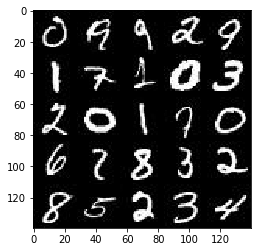

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

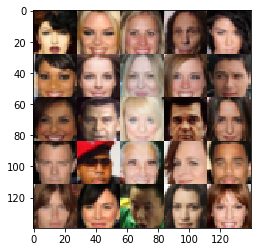

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.9)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.9)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.9)

        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.5)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.5)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.5)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
       
        out = tf.tanh(logits) 
   
    return out

  


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Change the range from (-0.5, 0.5) to (-1, 1) to be consistent with batch_z
                batch_images *= 2
                #print("Min/Max: {} / {}".format(np.min(batch_images), np.max(batch_images)))
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Get the losses and print them out after each 10 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4626... Generator Loss: 4.3689
Epoch 1/2... Discriminator Loss: 2.8663... Generator Loss: 6.5749
Epoch 1/2... Discriminator Loss: 1.7032... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.1327... Generator Loss: 6.0604
Epoch 1/2... Discriminator Loss: 0.8448... Generator Loss: 1.7636
Epoch 1/2... Discriminator Loss: 1.5018... Generator Loss: 0.7087
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 1.1171
Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 1.4102
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 0.9403
Epoch 1/2... Discriminator Loss: 1.2813... Generator Loss: 0.8429


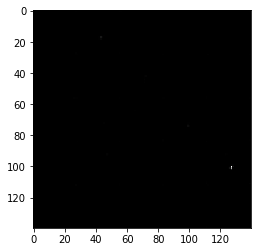

Epoch 1/2... Discriminator Loss: 1.6905... Generator Loss: 3.8248
Epoch 1/2... Discriminator Loss: 1.3295... Generator Loss: 2.9389
Epoch 1/2... Discriminator Loss: 1.2250... Generator Loss: 0.6944
Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 1.6605
Epoch 1/2... Discriminator Loss: 1.4227... Generator Loss: 2.1879
Epoch 1/2... Discriminator Loss: 1.0488... Generator Loss: 1.0307
Epoch 1/2... Discriminator Loss: 0.8447... Generator Loss: 1.3808
Epoch 1/2... Discriminator Loss: 0.7816... Generator Loss: 1.4647
Epoch 1/2... Discriminator Loss: 0.9245... Generator Loss: 1.0705
Epoch 1/2... Discriminator Loss: 1.2191... Generator Loss: 2.3285


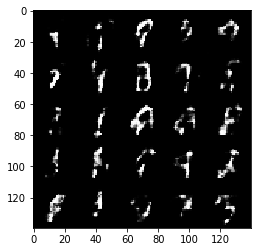

Epoch 1/2... Discriminator Loss: 1.8574... Generator Loss: 2.9787
Epoch 1/2... Discriminator Loss: 1.1944... Generator Loss: 1.3991
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 1.0677
Epoch 1/2... Discriminator Loss: 1.1970... Generator Loss: 1.7175
Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 1.0296
Epoch 1/2... Discriminator Loss: 1.6643... Generator Loss: 2.2959
Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 0.9859
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.7648
Epoch 1/2... Discriminator Loss: 1.4488... Generator Loss: 0.5661
Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 1.3762


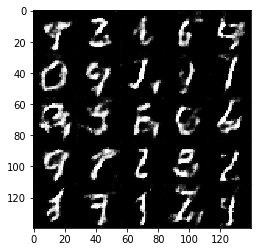

Epoch 1/2... Discriminator Loss: 1.2992... Generator Loss: 1.1910
Epoch 1/2... Discriminator Loss: 1.0020... Generator Loss: 1.4427
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 1.3547
Epoch 1/2... Discriminator Loss: 1.0388... Generator Loss: 2.0175
Epoch 1/2... Discriminator Loss: 1.1091... Generator Loss: 1.5213
Epoch 1/2... Discriminator Loss: 1.0854... Generator Loss: 0.9295
Epoch 1/2... Discriminator Loss: 1.0027... Generator Loss: 1.4017
Epoch 1/2... Discriminator Loss: 1.0967... Generator Loss: 0.9944
Epoch 1/2... Discriminator Loss: 1.8102... Generator Loss: 0.3445
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 0.9177


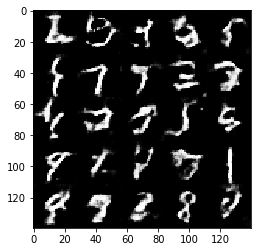

Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 1.0043
Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 1.0428
Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 2.2116
Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 1.2412
Epoch 1/2... Discriminator Loss: 1.3198... Generator Loss: 2.4682
Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 1.6478
Epoch 1/2... Discriminator Loss: 0.9239... Generator Loss: 1.5231
Epoch 1/2... Discriminator Loss: 0.9554... Generator Loss: 1.1937
Epoch 1/2... Discriminator Loss: 1.0932... Generator Loss: 0.9090
Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 1.2685


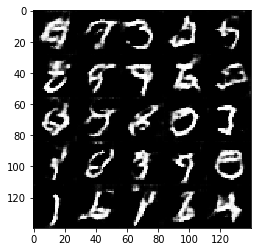

Epoch 1/2... Discriminator Loss: 0.9968... Generator Loss: 1.1653
Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 1.5096
Epoch 1/2... Discriminator Loss: 1.1580... Generator Loss: 2.3546
Epoch 1/2... Discriminator Loss: 0.8665... Generator Loss: 1.6599
Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 2.2013
Epoch 1/2... Discriminator Loss: 1.0172... Generator Loss: 1.9718
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 2.7957
Epoch 1/2... Discriminator Loss: 0.9279... Generator Loss: 1.3638
Epoch 1/2... Discriminator Loss: 1.7331... Generator Loss: 0.4066
Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 0.8633


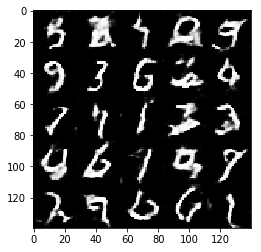

Epoch 1/2... Discriminator Loss: 0.9173... Generator Loss: 0.9987
Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 1.6141
Epoch 1/2... Discriminator Loss: 0.8133... Generator Loss: 1.5755
Epoch 1/2... Discriminator Loss: 1.0053... Generator Loss: 0.9659
Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 0.7570
Epoch 1/2... Discriminator Loss: 0.8469... Generator Loss: 1.3898
Epoch 1/2... Discriminator Loss: 0.9038... Generator Loss: 1.2538
Epoch 1/2... Discriminator Loss: 0.9069... Generator Loss: 1.4133
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 2.1993
Epoch 1/2... Discriminator Loss: 0.8476... Generator Loss: 1.7422


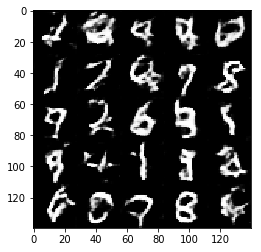

Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 2.2857
Epoch 1/2... Discriminator Loss: 0.9060... Generator Loss: 2.1949
Epoch 1/2... Discriminator Loss: 0.9882... Generator Loss: 2.3020
Epoch 1/2... Discriminator Loss: 0.9088... Generator Loss: 1.2088
Epoch 1/2... Discriminator Loss: 0.8133... Generator Loss: 1.6115
Epoch 1/2... Discriminator Loss: 0.8673... Generator Loss: 1.2540
Epoch 1/2... Discriminator Loss: 0.7509... Generator Loss: 1.6059
Epoch 1/2... Discriminator Loss: 1.1331... Generator Loss: 1.0117
Epoch 1/2... Discriminator Loss: 1.0639... Generator Loss: 0.9471
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 0.9040


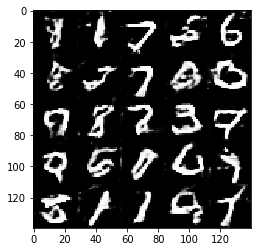

Epoch 1/2... Discriminator Loss: 1.0488... Generator Loss: 2.2003
Epoch 1/2... Discriminator Loss: 0.6663... Generator Loss: 1.5538
Epoch 1/2... Discriminator Loss: 0.8219... Generator Loss: 2.0422
Epoch 1/2... Discriminator Loss: 0.8846... Generator Loss: 1.5478
Epoch 1/2... Discriminator Loss: 1.5098... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 0.8446... Generator Loss: 1.2802
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 1.1761
Epoch 1/2... Discriminator Loss: 0.7176... Generator Loss: 2.0532
Epoch 1/2... Discriminator Loss: 0.7264... Generator Loss: 1.6425
Epoch 1/2... Discriminator Loss: 1.3333... Generator Loss: 0.5370


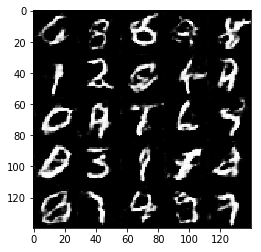

Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.6304
Epoch 1/2... Discriminator Loss: 1.0333... Generator Loss: 0.8151
Epoch 1/2... Discriminator Loss: 0.8710... Generator Loss: 2.2039
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.5810
Epoch 2/2... Discriminator Loss: 0.9078... Generator Loss: 1.7132
Epoch 2/2... Discriminator Loss: 0.9616... Generator Loss: 1.1086
Epoch 2/2... Discriminator Loss: 0.6773... Generator Loss: 2.0572
Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 1.1967
Epoch 2/2... Discriminator Loss: 0.6999... Generator Loss: 1.8838
Epoch 2/2... Discriminator Loss: 0.8256... Generator Loss: 1.2254


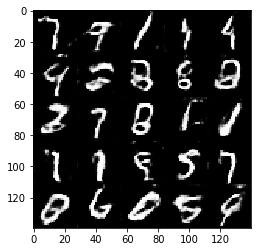

Epoch 2/2... Discriminator Loss: 0.8107... Generator Loss: 1.7143
Epoch 2/2... Discriminator Loss: 1.1157... Generator Loss: 2.4655
Epoch 2/2... Discriminator Loss: 0.7674... Generator Loss: 1.5667
Epoch 2/2... Discriminator Loss: 0.8533... Generator Loss: 1.5714
Epoch 2/2... Discriminator Loss: 0.8653... Generator Loss: 1.5189
Epoch 2/2... Discriminator Loss: 1.1390... Generator Loss: 2.4300
Epoch 2/2... Discriminator Loss: 0.7324... Generator Loss: 1.4193
Epoch 2/2... Discriminator Loss: 0.7388... Generator Loss: 1.8213
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 1.8268
Epoch 2/2... Discriminator Loss: 1.0810... Generator Loss: 1.2148


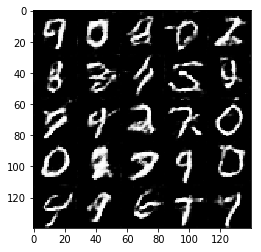

Epoch 2/2... Discriminator Loss: 0.8133... Generator Loss: 1.6579
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 2.9948
Epoch 2/2... Discriminator Loss: 0.7465... Generator Loss: 1.6645
Epoch 2/2... Discriminator Loss: 0.8234... Generator Loss: 1.3955
Epoch 2/2... Discriminator Loss: 0.7554... Generator Loss: 1.3972
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 0.9972
Epoch 2/2... Discriminator Loss: 1.3411... Generator Loss: 3.3465
Epoch 2/2... Discriminator Loss: 0.6764... Generator Loss: 1.9305
Epoch 2/2... Discriminator Loss: 0.9071... Generator Loss: 1.1193
Epoch 2/2... Discriminator Loss: 0.7132... Generator Loss: 1.7184


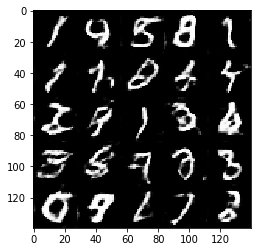

Epoch 2/2... Discriminator Loss: 0.7049... Generator Loss: 1.4683
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 1.7122
Epoch 2/2... Discriminator Loss: 0.8147... Generator Loss: 1.2876
Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 2.3959
Epoch 2/2... Discriminator Loss: 0.5943... Generator Loss: 1.9897
Epoch 2/2... Discriminator Loss: 0.6981... Generator Loss: 2.0880
Epoch 2/2... Discriminator Loss: 0.6638... Generator Loss: 2.7903
Epoch 2/2... Discriminator Loss: 0.6159... Generator Loss: 2.3269
Epoch 2/2... Discriminator Loss: 0.5852... Generator Loss: 3.5234
Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 2.6581


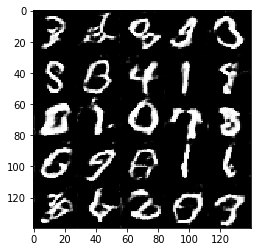

Epoch 2/2... Discriminator Loss: 1.1540... Generator Loss: 0.8929
Epoch 2/2... Discriminator Loss: 1.1190... Generator Loss: 2.7675
Epoch 2/2... Discriminator Loss: 0.7920... Generator Loss: 1.5307
Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 1.3778
Epoch 2/2... Discriminator Loss: 0.8100... Generator Loss: 2.3176
Epoch 2/2... Discriminator Loss: 0.8830... Generator Loss: 1.4521
Epoch 2/2... Discriminator Loss: 0.7720... Generator Loss: 2.1184
Epoch 2/2... Discriminator Loss: 1.2293... Generator Loss: 0.7800
Epoch 2/2... Discriminator Loss: 0.6885... Generator Loss: 1.4540
Epoch 2/2... Discriminator Loss: 1.7924... Generator Loss: 4.0402


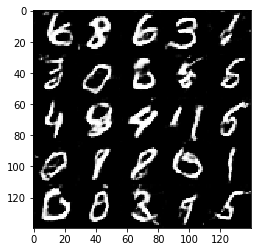

Epoch 2/2... Discriminator Loss: 0.6119... Generator Loss: 2.0495
Epoch 2/2... Discriminator Loss: 0.9229... Generator Loss: 1.1019
Epoch 2/2... Discriminator Loss: 0.6478... Generator Loss: 2.1777
Epoch 2/2... Discriminator Loss: 0.7130... Generator Loss: 1.4861
Epoch 2/2... Discriminator Loss: 0.8817... Generator Loss: 1.2395
Epoch 2/2... Discriminator Loss: 0.6505... Generator Loss: 2.7275
Epoch 2/2... Discriminator Loss: 0.7430... Generator Loss: 2.6951
Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 2.4850
Epoch 2/2... Discriminator Loss: 0.5270... Generator Loss: 2.3526
Epoch 2/2... Discriminator Loss: 0.5963... Generator Loss: 2.3966


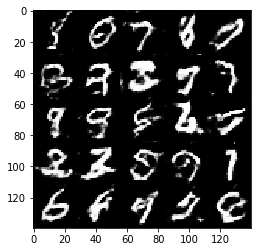

Epoch 2/2... Discriminator Loss: 0.7309... Generator Loss: 1.7745
Epoch 2/2... Discriminator Loss: 1.0335... Generator Loss: 1.2665
Epoch 2/2... Discriminator Loss: 0.5941... Generator Loss: 2.0005
Epoch 2/2... Discriminator Loss: 1.8212... Generator Loss: 4.2094
Epoch 2/2... Discriminator Loss: 0.6063... Generator Loss: 1.5054
Epoch 2/2... Discriminator Loss: 0.7810... Generator Loss: 2.6878
Epoch 2/2... Discriminator Loss: 0.6037... Generator Loss: 2.7850
Epoch 2/2... Discriminator Loss: 0.6296... Generator Loss: 2.2161
Epoch 2/2... Discriminator Loss: 0.7756... Generator Loss: 1.6360
Epoch 2/2... Discriminator Loss: 0.5816... Generator Loss: 3.1889


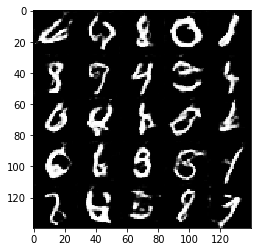

Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 2.2214
Epoch 2/2... Discriminator Loss: 0.7922... Generator Loss: 1.5704
Epoch 2/2... Discriminator Loss: 0.6320... Generator Loss: 2.1280
Epoch 2/2... Discriminator Loss: 0.5054... Generator Loss: 2.8749
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 1.3652
Epoch 2/2... Discriminator Loss: 2.5606... Generator Loss: 0.2809
Epoch 2/2... Discriminator Loss: 0.7198... Generator Loss: 2.9179
Epoch 2/2... Discriminator Loss: 0.5349... Generator Loss: 2.2520
Epoch 2/2... Discriminator Loss: 0.6326... Generator Loss: 1.6741
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 2.3615


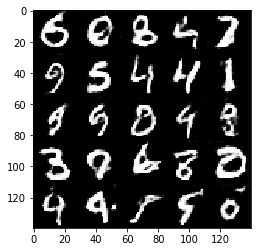

Epoch 2/2... Discriminator Loss: 0.4662... Generator Loss: 2.6939
Epoch 2/2... Discriminator Loss: 0.6863... Generator Loss: 1.2268
Epoch 2/2... Discriminator Loss: 0.5765... Generator Loss: 1.9366
Epoch 2/2... Discriminator Loss: 0.5890... Generator Loss: 2.0617
Epoch 2/2... Discriminator Loss: 0.4945... Generator Loss: 3.5216
Epoch 2/2... Discriminator Loss: 1.3263... Generator Loss: 4.1124
Epoch 2/2... Discriminator Loss: 0.6227... Generator Loss: 2.8444
Epoch 2/2... Discriminator Loss: 0.6399... Generator Loss: 2.1595
Epoch 2/2... Discriminator Loss: 0.6865... Generator Loss: 1.3999
Epoch 2/2... Discriminator Loss: 0.6495... Generator Loss: 1.8300


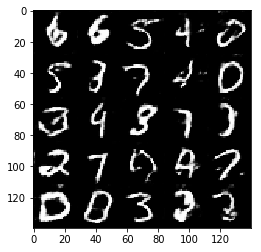

Epoch 2/2... Discriminator Loss: 0.6252... Generator Loss: 1.8873
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 0.8958
Epoch 2/2... Discriminator Loss: 0.5764... Generator Loss: 2.5213
Epoch 2/2... Discriminator Loss: 0.5760... Generator Loss: 2.4260
Epoch 2/2... Discriminator Loss: 0.6966... Generator Loss: 2.6916
Epoch 2/2... Discriminator Loss: 0.5285... Generator Loss: 2.9804
Epoch 2/2... Discriminator Loss: 0.4911... Generator Loss: 2.8603


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 4.0687
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 10.2429
Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 3.4114
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 3.3420
Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 4.7723
Epoch 1/1... Discriminator Loss: 0.4379... Generator Loss: 5.1287
Epoch 1/1... Discriminator Loss: 0.4012... Generator Loss: 4.7596
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 1.5368
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 8.3115


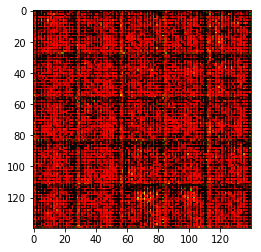

Epoch 1/1... Discriminator Loss: 0.5792... Generator Loss: 1.8570
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 3.1048
Epoch 1/1... Discriminator Loss: 3.6505... Generator Loss: 10.4549
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 1.1704
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 2.5392
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 2.4083... Generator Loss: 2.0231
Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 1.6902
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.5923


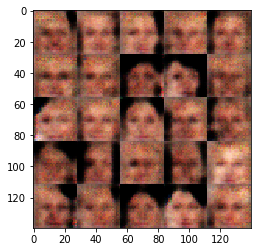

Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 2.1446
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.0748
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.7045
Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 1.6907
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 1.2953
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 1.3389
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 1.4699


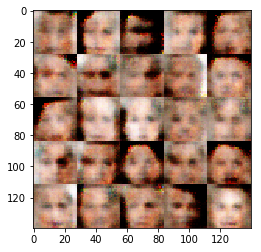

Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.3640
Epoch 1/1... Discriminator Loss: 1.7248... Generator Loss: 0.3402
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 2.0987
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 1.2462
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 1.7897
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 2.3764
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.1132
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.5692


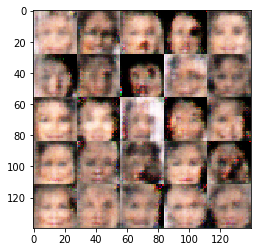

Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 1.3038
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 2.1265... Generator Loss: 2.5473
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 1.2086
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.3744
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 1.8555
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.7306


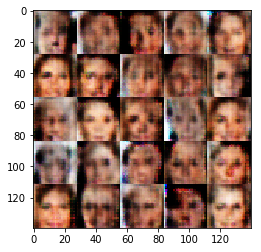

Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 2.1233
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 1.4617
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.8647


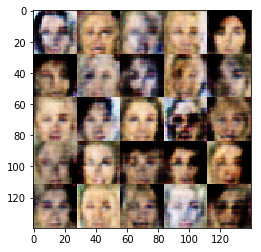

Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.2132
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 2.0034... Generator Loss: 2.3530
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.5822... Generator Loss: 0.3701
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.8987... Generator Loss: 0.3319


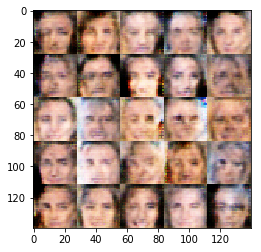

Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 1.3389
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 1.3093
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 1.2939
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 1.3489
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.9975


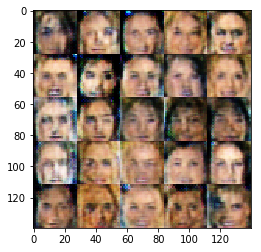

Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 1.7317
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 1.1818


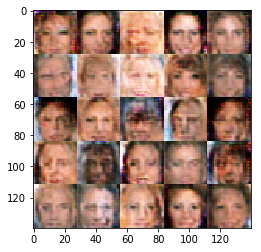

Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 1.2846
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.4603
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.3736
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 1.6078
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 1.2946
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 1.0582


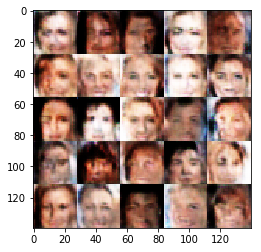

Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 1.5448
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 1.0258
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.0136


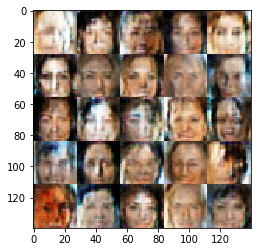

Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.7432


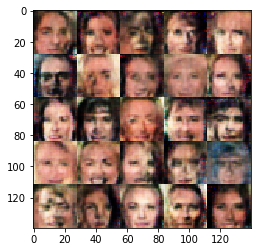

Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.6999


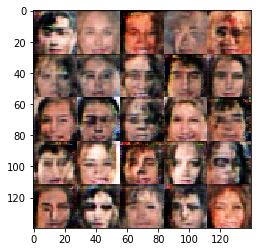

Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 1.2113


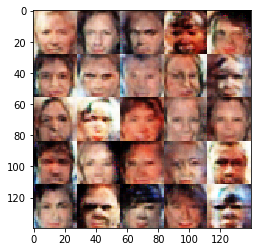

Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 1.2662
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 1.6206
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 1.0227


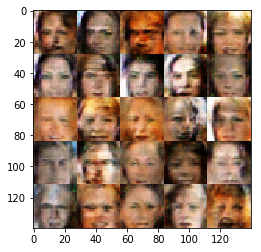

Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 1.2155


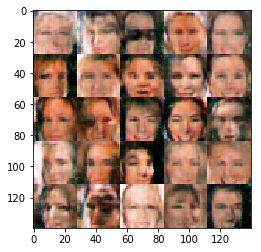

Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 1.1719
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.9399


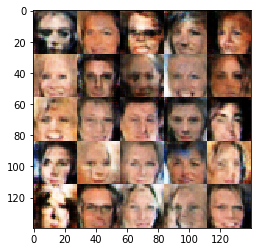

Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 1.1537
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 1.2894
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.8474


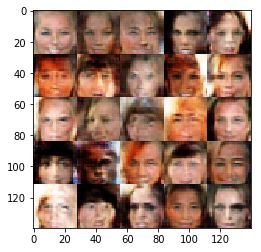

Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.6413... Generator Loss: 1.4078
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 1.1843
Epoch 1/1... Discriminator Loss: 1.8225... Generator Loss: 2.3590
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 1.3322
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 1.1207


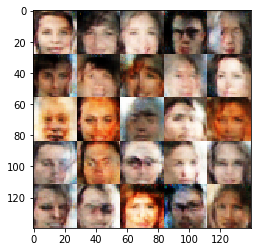

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.1326
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 1.2499


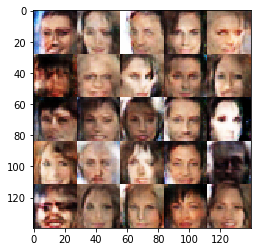

Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.0257
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 1.3933
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 1.8788
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 1.2742
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 1.1381


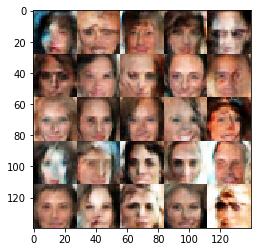

Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 1.1300
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 1.2795
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 1.3422
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.5052
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 1.2922


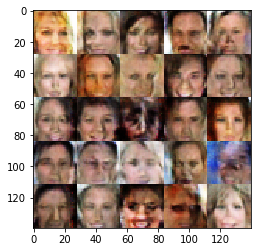

Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 1.3730
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.8514... Generator Loss: 0.3312
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 1.0087


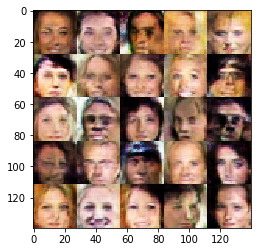

Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 1.3093
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.9547
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.0158


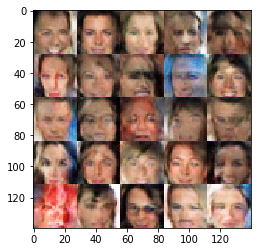

Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 1.2101
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.0382


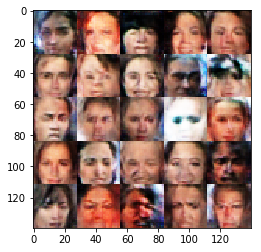

Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 1.3283
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 1.3317
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 1.5822
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.8194


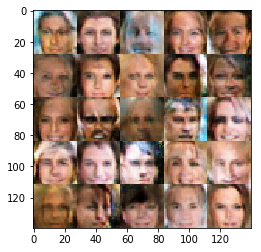

Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.7043... Generator Loss: 2.0972
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.9134


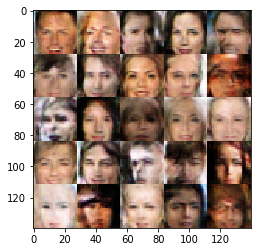

Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 1.6508
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.0186


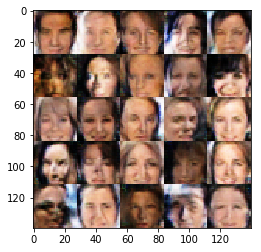

Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 1.3685
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.4268
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 1.2360
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 1.5293
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.9914


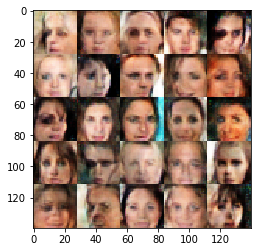

Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.5284
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 1.3395
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 1.3197
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.3037
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 2.0444
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 1.3799
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.8601


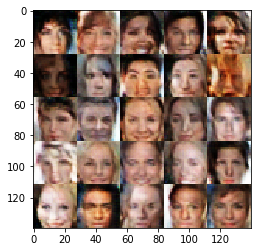

Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 1.1333
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.9422


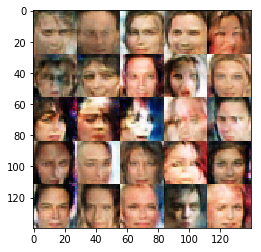

Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.2780
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 1.6353
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 1.2949
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.8923


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.